<a href="https://colab.research.google.com/github/cbizz2050/mnist_number_classifier/blob/main/custom_num_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import common datasets
from sklearn.datasets import fetch_openml

# 28 x 28 grey scale images
mnist = fetch_openml('mnist_784', as_frame=False)

# images of numbers, associated value of number in image
X,y = mnist.data, mnist.target

#
# X_train: Input images for training set
# X_test: Input images for test set
# y_train: Actual value of hand written number for test set
# y_test: Actual value of hand written number included in test set
#
##  Split training set from testing set 6:1 (70000 total samples)
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]


In [5]:
from sklearn.neighbors import KNeighborsClassifier
kn_clf = KNeighborsClassifier(n_neighbors=2)
kn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [6]:
# Cross-Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

y_predict = cross_val_predict(kn_clf, X_train, y_train)
y_kn_score = cross_val_score(kn_clf, X_train, y_train)


In [7]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_predict)
cm

array([[5902,    3,    2,    0,    1,    4,    6,    2,    1,    2],
       [   4, 6723,    7,    0,    2,    0,    0,    4,    1,    1],
       [  62,   61, 5746,   10,    7,    6,    5,   47,   12,    2],
       [  14,   17,   60, 5943,    2,   38,    1,   23,   20,   13],
       [  10,   61,    4,    0, 5699,    0,    7,    8,    2,   51],
       [  23,   12,    6,  155,   18, 5158,   37,    2,    2,    8],
       [  48,   13,    4,    1,   10,   39, 5802,    0,    1,    0],
       [   5,   75,   28,    5,   31,    1,    0, 6083,    3,   34],
       [  35,   96,   44,  159,   38,  146,   48,   29, 5230,   26],
       [  25,   13,    8,   41,  154,   20,    3,  164,   18, 5503]])

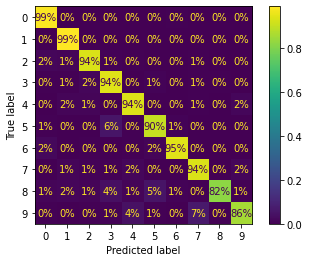

In [8]:
# Standard Scalar applied to CM (is this necessary?)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
std_scaler = StandardScaler()
cm_scaled = std_scaler.fit_transform(cm)
cm_scaled.round(2)

# Use scaled x for normalized confusion matrix display
x_train_scaled = std_scaler.fit_transform(X_train)
y_predict_scaled = cross_val_predict(kn_clf, x_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_predict_scaled, normalize="true", values_format=".0%")
plt.show()


In [9]:
# 0 - kn_clf - 99% - good
# 1 - kn_clf - 99% - good
# 2 - kn_clf - 94% - fair
# 3 - kn_clf - 94% - fair
# 4 - kn_clf - 94% - fair
# 5 - kn_clf - 90% - bad
# 6 - kn_clf - 95% - fair
# 7 - kn_clf - 94% - fair
# 8 - kn_clf - 82% - bad
# 9 - kn_clf - 86% - bad
from sklearn.metrics import mean_squared_error
kn_rmse = mean_squared_error(y_predict, y_train)
kn_rmse


0.6549666666666667

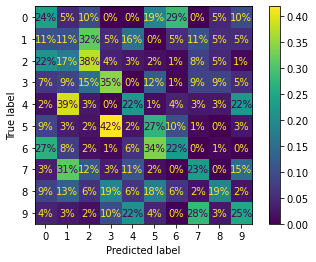

In [10]:
sample_weights = (y_predict != y_train) # Make the weight of each pixel dependent on the prediction not being the same as the actual data, ie. errors only)
ConfusionMatrixDisplay.from_predictions(y_train, y_predict_scaled, sample_weight=sample_weights, normalize="true", values_format=".0%")
plt.show()

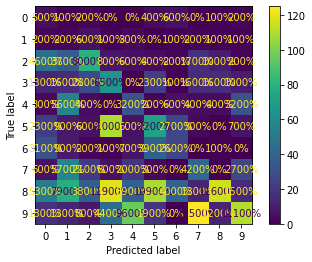

In [11]:
# NOT normalized - shows more detailed view of which are causing errors
sample_weights = (y_predict != y_train) # This reports only errors
ConfusionMatrixDisplay.from_predictions(y_train, y_predict_scaled, sample_weight=sample_weights, values_format=".0%")
plt.show()

In [12]:
# This shows that a majority of the errors occur;
#
# 8 mistaken for 3
# 5 mistaken for 2
#
# 9 mistaken for 4
# 9 mistaken for 7

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]

grid_search = GridSearchCV(kn_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=2),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [14]:
final_clf = grid_search.best_estimator_

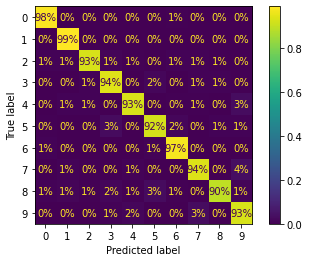

In [15]:
# Use scaled x for normalized confusion matrix display
X_train_scaled = std_scaler.fit_transform(X_train)
y_predict_scaled = cross_val_predict(final_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_predict_scaled, normalize="true", values_format=".0%")
plt.show()


In [16]:
y_final_score = cross_val_score(final_clf, X_train, y_train)

y_final_score

array([0.973     , 0.97225   , 0.96991667, 0.97091667, 0.972     ])

In [22]:
# The above two charts show the accuracy of the model has increased substantially by;
#    1) Adding gridSearch to identify the best estimator based on the weight settings and n_neigbors
#    2) Adding a scalar transform to the mix
y_accuracy_increase = y_final_score - y_kn_score
y_accuracy_increase


array([0.00883333, 0.00941667, 0.00841667, 0.00775   , 0.00791667])

In [ ]:
# Ideas for improvement;
#  1) Add a method to add noise and retrain on specific numbers to see if that helps 
#  2) Consider a different n_neighbor value for kn_clf